In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [4]:
from torchvision import datasets

data_path = '../data/p1ch7/'
cifar10 = datasets.CIFAR10(data_path,train = True,download=True)
cifar10_val = datasets.CIFAR10(data_path,train = False,download=True)

Extracting ../data/p1ch7/cifar-10-python.tar.gz to ../data/p1ch7/
Files already downloaded and verified


In [6]:
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/p1ch7/
    Split: Train

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [9]:
img,label = cifar10[99]
img,label,class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F66A18AF1D0>,
 1,
 'automobile')

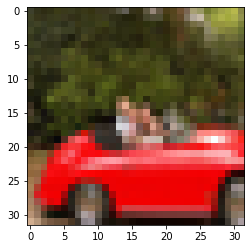

In [11]:
plt.imshow(img)
plt.show()

In [13]:
# 数据转换为tensor

from torchvision import transforms
to_tensor = transforms.ToTensor()

img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [14]:
# 整个数据

tensor_cifar10 = datasets.CIFAR10(data_path,train = True,download=False,transform=transforms.ToTensor())

In [49]:
img_t,_ = tensor_cifar10[99]
type(img_t)

torch.Tensor

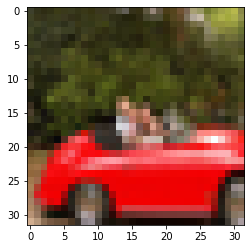

In [50]:
plt.imshow(img_t.permute(1,2,0))

In [18]:
# 数据标准化
imgs = torch.stack([img_t for img_t,_ in tensor_cifar10],dim = 3)  # 在一个维度上把tensor堆叠起来
imgs.shape

torch.Size([3, 32, 32, 50000])

In [24]:
imgs.view(3,-1).mean(dim=1   # 计算各个通道的均值

tensor([0.4915, 0.4823, 0.4468])

In [25]:
imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [26]:
transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [63]:
# 在数据集中标准化
transformed_cifar10 = datasets.CIFAR10(data_path,train = True,download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                                (0.2470, 0.2435, 0.2616))
                                       ]))

In [64]:
transformed_cifar10_val = datasets.CIFAR10(data_path,train = False,download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                                (0.2470, 0.2435, 0.2616))
                                       ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


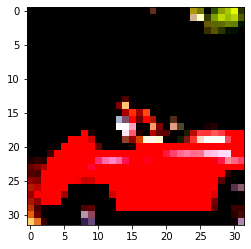

In [46]:
img_t,_=transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))

In [66]:
label_map = {0:0,2:1}   # 把原来的标签映射过来

class_names = ['airplane','bird']

cifar2 = [(img,label_map[label]) for img,label in transformed_cifar10 
          if label in [0,2]] # 把 0 2 图像及对应标签取出，赋值给img和映射的标签
cifar2_val = [(img,label_map[label]) for img,label in cifar10_val 
              if label in [0,2]]

In [67]:
import torch.nn as nn

n_out = 2
model = nn.Sequential(
            nn.Linear(3072,512),
            nn.Tanh(),
            nn.Linear(512,n_out))

In [68]:
# 使用softmax分类
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

# 使用nn.Softmax() 时应该指定维度

softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],
[1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [79]:
model = nn.Sequential(
            nn.Linear(3072,512),
            nn.Tanh(),
            nn.Linear(512,n_out),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


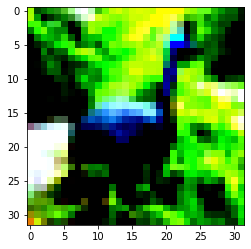

In [80]:
# 训练之前测试看一下model的输出是什么

img, _ = cifar2[0]

plt.imshow(img.permute(1,2,0))

In [81]:
# 制作bathszie

img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)                         # 经过训练（loss函数会指引输出的结果中对应正确类别的标签数字最大）
out

tensor([[0.3347, 0.6653]], grad_fn=<SoftmaxBackward>)

In [82]:
_,index = torch.max(out,dim=1)
index

tensor([1])

### 如何选取loss函数

我们的目的是最大化与正确类别对应的概率，比如[1,0]代表飞机，[0,1]代表鸟。因此在训练时，如果样本是飞机，应该使输出中第一个元素（索引为[0]）最大，我们称此[0]对应的数字为可能性（也就是概率）。我们的目的是最小化loss，因此如果输出是飞机的可能性很小（而实际上就是飞机），应该让loss很大，代表此时的loss不是我们想要的程度，随着训练，loss变小，这表明此时的可能性变大。

根据这个思路，loos应该是当可能性很小的时候loss很大，当可能性很大时loss很小

pytorch中的nn.NLLLoss就是这样一个函数，但是它的输入要求为对数，因此softmax的输出也应该是对数，可以用logsoftmax来代替

In [83]:
model = nn.Sequential(
            nn.Linear(3072,512),
            nn.Tanh(),
            nn.Linear(512,n_out),
            nn.LogSoftmax(dim=1))

In [87]:
loss = nn.NLLLoss()

In [88]:
# 测试loss
img,label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))  

loss(out,torch.tensor([label]))    # loss的输入: 第一个参数为softmax的输出；第二个参数是groundtruth的标签（飞机为0，鸟为1）

tensor(0.8193, grad_fn=<NllLossBackward>)

In [89]:
out

tensor([[-0.5812, -0.8193]], grad_fn=<LogSoftmaxBackward>)

In [90]:
label

1

(tensor([[[ 0.6139, -0.3228,  ..., -0.2752, -0.5451],
          [ 0.6615, -0.1482,  ..., -0.3228, -0.5768],
          ...,
          [ 0.5980,  0.4393,  ..., -0.4340,  0.0265],
          [ 0.9156,  0.8044,  ..., -0.5451, -0.0529]],
 
         [[ 1.3369,  0.2740,  ...,  0.3867,  0.0968],
          [ 1.4497,  0.5961,  ...,  0.3062,  0.0646],
          ...,
          [ 0.5478,  0.6605,  ...,  0.4028,  0.8860],
          [ 0.4834,  0.9504,  ...,  0.1613,  0.7572]],
 
         [[-0.4487, -0.7935,  ..., -0.6736, -0.8535],
          [-0.4487, -0.9734,  ..., -0.6286, -0.8535],
          ...,
          [-0.4337, -0.4787,  ..., -1.3032, -0.9884],
          [-0.1789,  0.0310,  ..., -1.3182, -1.0484]]]),
 1)